In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
from data_loaders import load_nature 

nature = load_nature("WENO_FULLRES")

nature_profiles, nature_ts = nature.observable.obs_xr_full

Using custom matplotlib style from 'mplstyle' file


Reading full profiles and timeseries for ObEnsembleDYCOMS_RF01...
	[create_mfdataset_with_nans()] Found 1 files.


/cluster/work/climate/dgrund/git/dana-grund/CalPyCLES/environment/.venv/calpycles/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


	[create_mfdataset_with_nans()] Found 1 files.


In [5]:
### diagnose inversion = cloud top as z(qt=8)

qt = nature_profiles["qt_mean"]
qt_threshold = 8

data = qt.isel(sample=0)
z_values = data.z.values

crossing_heights = []
for time_idx in range(data.sizes['t']):
    # Extract qt_mean profile at this time (across all z levels)
    qt_profile = data.isel(t=time_idx)  # shape: (z,)
    
    # Check if threshold is within the range
    if qt_profile.min() <= qt_threshold <= qt_profile.max():
        # Interpolate to find height where qt_mean crosses threshold
        # If qt decreases with height (typical), reverse for monotonic interpolation
        if qt_profile[0] > qt_profile[-1]:
            height = np.interp(qt_threshold, qt_profile.values[::-1], z_values[::-1])
        else:
            height = np.interp(qt_threshold, qt_profile.values, z_values)
    else:
        height = np.nan
    
    crossing_heights.append(height)

# Convert to xarray DataArray for easy plotting
inv_height_qt8 = xr.DataArray(
    crossing_heights,
    dims=['t'],
    coords={'t': data.t.values}
)

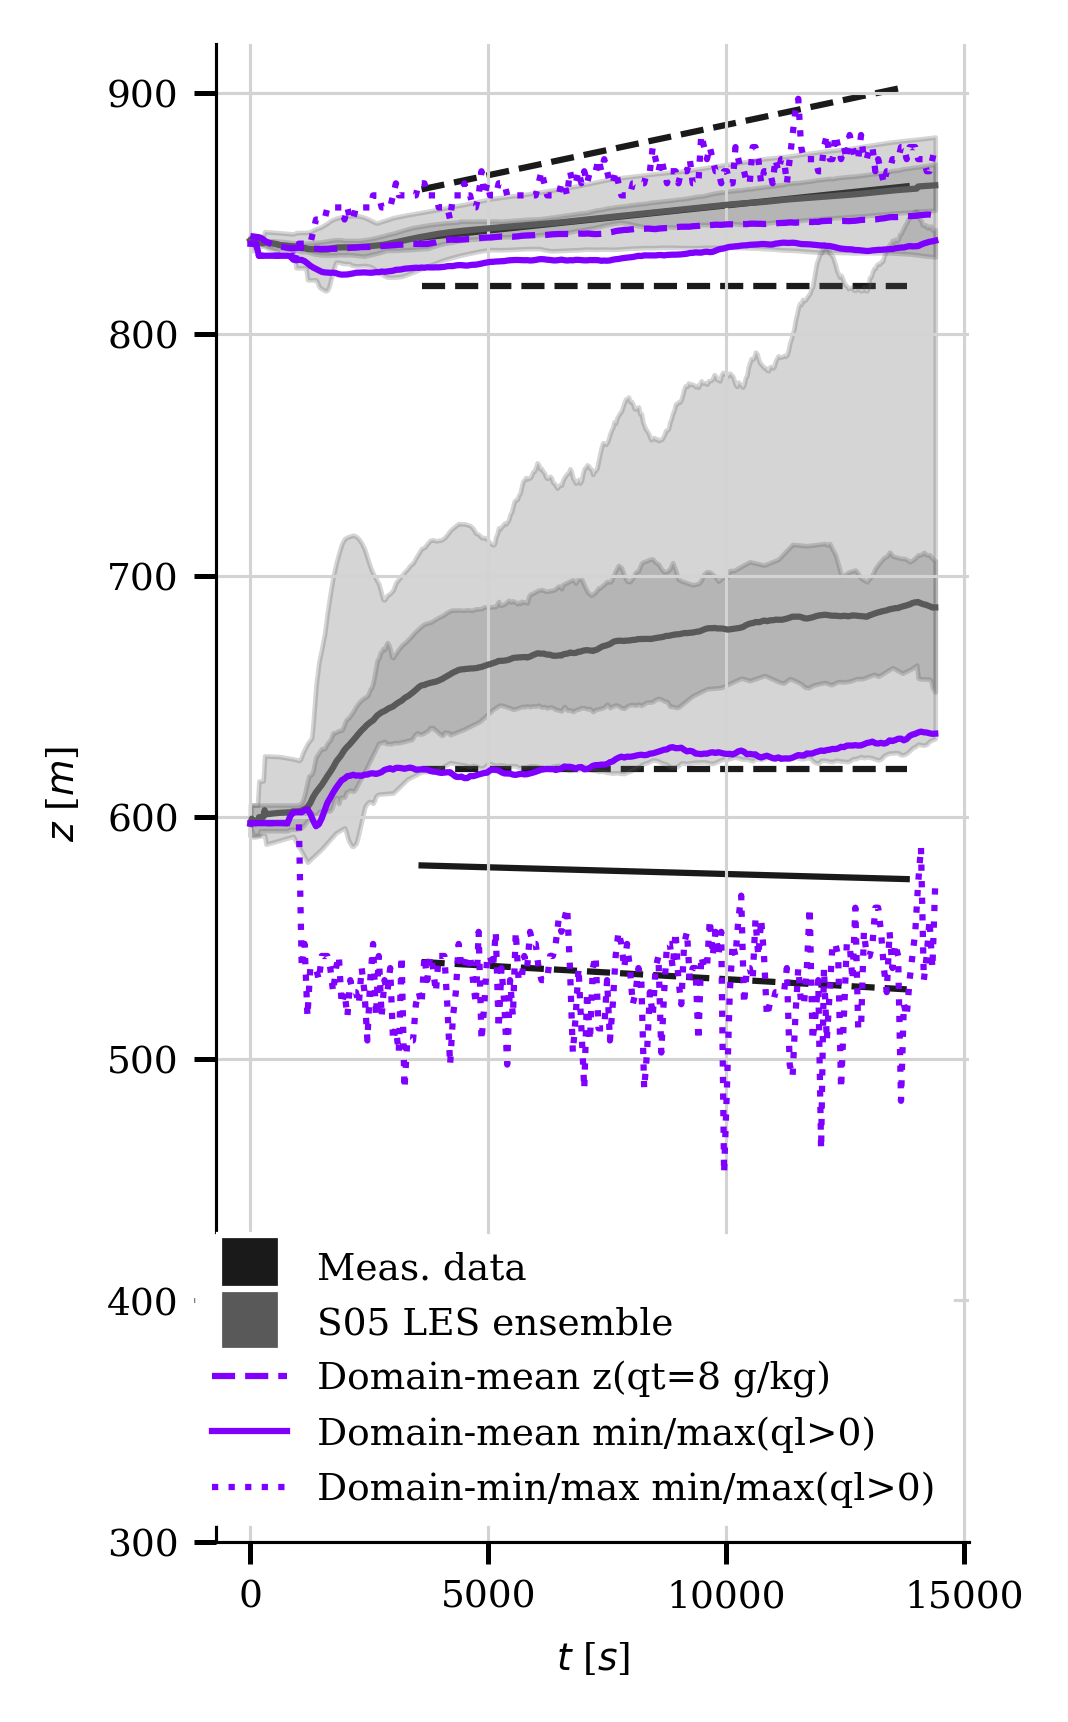

Saved figure  figs/fig-cloud_defs


In [30]:
from calpycles.plotting import C_NATURE
from calpycles.plotting import C_MEAS
from calpycles.plotting import color_handles
from calpycles.plotting import get_name_mpl
from calpycles.plotting import make_figure
from calpycles.plotting import save_figure

from calpycles.plotting.ens_obs import _plot_S05_ts
from calpycles.plotting.ens_obs import C_S05

from calpycles.DYCOMS_RF01.measurements import MeasurementsDYCOMS_RF01
meas = MeasurementsDYCOMS_RF01()

fig, axs = make_figure(1,1,width=6, horizontal=False)
ax = axs[0]

_plot_S05_ts(ax, "cloud_top")
_plot_S05_ts(ax, "cloud_base")

kwargs = dict(
    ax=ax,
    x="t",
    c=C_NATURE,
)

p3 = nature_ts["cloud_top_mean"].plot(label="Domain-mean min/max(ql>0)", **kwargs)[0]
nature_ts["cloud_base_mean"].plot(**kwargs)

p2 = inv_height_qt8.plot(linestyle="--", label="Domain-mean z(qt=8 g/kg)", **kwargs)[0]

nature_ts["cloud_top"].plot(linestyle=":", **kwargs)
p4 = nature_ts["cloud_base"].plot(linestyle=":", label="Domain-min/max min/max(ql>0)", **kwargs)[0]

meas.plot_timeseries(ax, "cloud_top") # handles: mean; std
meas.plot_timeseries(ax, "cloud_base")

handles = color_handles(
    [
        "Meas. data",
        "S05 LES ensemble",
    ],
    [
        C_MEAS,
        C_S05,
    ]
)

ax.legend(handles=handles+[p2,p3,p4], loc="lower right")

ax.set_ylim(300,920)
ax.set_ylabel(get_name_mpl("z"))
ax.set_xlabel(get_name_mpl("t"))
ax.set_title("")

save_figure("figs/fig-cloud_defs")